In [1]:
%pylab notebook
import numpy as np
from copy import copy

Populating the interactive namespace from numpy and matplotlib


In [2]:
def random_choice(a, p=None):
    return list(a)[np.random.choice(len(a), p=p)]

def sarsa_iter(S, initialize, terminal, R, gamma, alpha, Q, policy):
    s = initialize()
    a = sample_action(policy, s)
    while True:
        if terminal(s):
            break
        s2, r = R(s, a)
        a2 = sample_action(policy, s2)
        Q[s, a] += alpha * (r + gamma * Q[s2, a2] - Q[s, a])
        s, a = s2, a2

def greedy(Q, A):      
    def policy(s):
        return max(A(s), key = lambda a: Q[s, a])
    return policy
    
def epsilon_greedy(A, greedy, epsilon):
    def policy(s):
        As = A(s)
        n = len(As)
        res = { a: epsilon / (n-1) for a in As if a != greedy(s)}
        if greedy(s) is not None:
            res[greedy(s)] = 1 - epsilon
        return res
    return policy

def sample_action(policy, s):
    actions = policy(s)
    return random_choice(actions.keys(), actions.values())

In [3]:
DIAGONALS = True
STOCHASTIC_WIND = False

# Windy Gridworld
WIDTH = 10
HEIGHT = 7
START = (0, 3)
GOAL = (7, 3)
WIND = [ 0, 0, 0, 1, 1, 1, 2, 2, 1, 0 ]

GAMMA = 1

S = [ (x, y) for x in xrange(WIDTH) for y in xrange(HEIGHT)]
initialize = lambda: random_choice(S)
terminal = lambda s: s == GOAL
def R(s, a):
    x, y = s
    vx, vy = a
    wind = WIND[x]
    if wind and STOCHASTIC_WIND:
        wind += random_choice([-1, 0, 1])
    x2 = x + vx
    x2 = max(0, min(x2, WIDTH - 1))
    y2 = y + vy
    y2 = max(0, min(y2, HEIGHT - 1))
    y2 += wind
    y2 = max(0, min(y2, HEIGHT - 1))
    s2 = x2, y2
    r = -1
    return s2, r
A = lambda s: [ (1, 0), (-1, 0), (0, 1), (0, -1) ] + ([ (-1, 1), (1, 1), (1, -1), (-1, -1) ] if DIAGONALS else [])

Q0 = { (s, a): 0. for s in S for a in A(s) }

ACTION_LABELS = { 
    (-1,  0): '←', 
    ( 1,  0): '→', 
    ( 0, -1): '↓', 
    ( 0,  1): '↑', 
    (-1,  1): '↖', 
    ( 1,  1): '↗', 
    ( 1, -1): '↘', 
    (-1, -1): '↙',
}

In [4]:
Q = copy(Q0)
EPSILON = 0.1

greedy_policy = greedy(Q, A)
policy = epsilon_greedy(A, greedy_policy, EPSILON)

alpha = 0.1

In [5]:
%%time
for _ in xrange(10000):
    sarsa_iter(S, initialize, terminal, R, GAMMA, alpha, Q, policy)

CPU times: user 5.53 s, sys: 24 ms, total: 5.56 s
Wall time: 5.54 s


↓ ↙ ↙ ← → → ↘ ↗ → ↘
↘ ↓ ↙ ↓ → ↘ ↗ → ↘ ↓
↘ ↘ ↓ ↙ ↗ → ↗ ↘ ↘ ↙
↘ ↘ ↘ ↙ ↘ ↘ ↘ → ↙ ↙
→ ↘ → ↘ ↘ ↘ ↘ ↓ ← ↙
↓ ↗ → ↘ → ↘ → ↓ ↖ ←
↗ → ↗ → ↓ → ↗ ↑ ↓ ↖
[[ -8.1  -7.4  -6.6  -6.3  -3.5  -2.1  -1.   -1.   -2.1  -2.2]
 [ -8.1  -7.4  -6.7  -6.   -4.2  -2.8  -1.   -2.   -1.   -2. ]
 [ -8.2  -7.4  -6.8  -6.6  -4.8  -2.6  -1.   -1.   -1.   -2.1]
 [ -8.2  -7.7  -6.9  -7.9  -9.2  -8.2  -7.1   0.   -1.   -2.7]
 [ -8.5  -7.9  -7.9  -9.  -10.   -9.2  -8.2  -6.   -4.1  -2.2]
 [ -9.1  -9.2  -9.  -10.1 -10.2  -9.2  -8.2  -7.   -4.7  -3.4]
 [ -9.9  -9.9 -10.1 -10.8 -10.2  -9.3  -8.2  -7.2  -5.8  -4.7]]


<IPython.core.display.Javascript object>


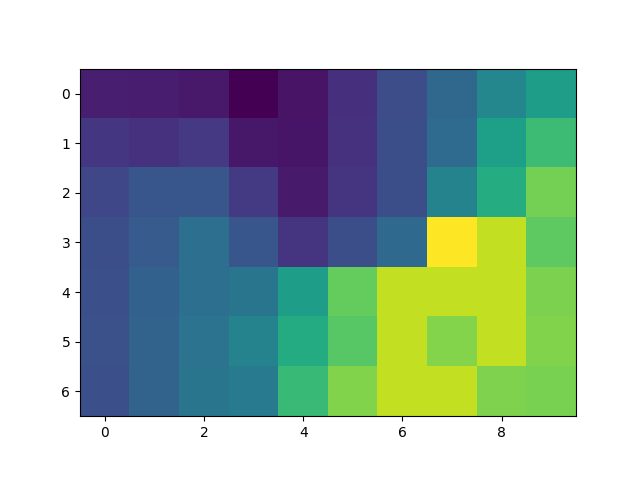

In [6]:
V = { s: max(Q[s, a] for a in A(s)) for s in S }
for y in range(HEIGHT)[::-1]:
    for x in range(WIDTH):
        print ACTION_LABELS[greedy_policy((x, y))],
    print

Vmat = numpy.array([ [ V[x, y] for x in xrange(WIDTH) ]  for y in xrange(HEIGHT) ])
np.set_printoptions(precision=1)
print Vmat
figure()
imshow(Vmat[::-1])

In [8]:
def trajectory(s, R, policy):
    traj = [ ]
    while True:
        a = policy(s)
        traj.append((s, a))
        if terminal(s):
            break
        s, r = R(s, a)
    return traj

def print_trajectory(traj):
    grid = [ [ '.' for x in xrange(WIDTH) ] for y in xrange(HEIGHT) ]
    for ((x, y), a) in traj:
        grid[y][x] = ACTION_LABELS.get(a, '?')
    grid[GOAL[1]][GOAL[0]] = 'G'
    for line in grid[::-1]:
        print ''.join(line)

In [9]:
traj = trajectory((0, 3), R, greedy_policy)
print_trajectory(traj)
print ''.join(map(str, WIND))
print "length:", len(traj)

..........
..........
..........
↘......G..
.↘...↘↘...
..→↘→.....
..........
0001112210
length: 8
